> ## **[개요]**

- 목적 : 자율주행차의 Radar 생산 과정에서의 공정 Data를 통해 Radar의 최종 성능 예측
- 활용 데이터 ('train.csv' data 참고)   
   - 자율 주행 센서 제조 공정에서 수집된 데이터 (39,607건)
   - X Feature (56개) : 자율주행 센서 조립 공정에서 세팅한 인자값 
   - Y Feature (14개) : 최종 센서의 성능

- 데이터 전처리
  - 결측치가 존재하는 경우 해당 행은 제거 
  - 모두 동일한 값을 가지는 column 제거 (특정 featuer가 모든 샘플에 같은 상수 값을 가짐)
  - column끼리 비교하여 같은 값을 가지는 columns들이 있다면 제거 

- 데이터 시각화
  - 데이터 구조를 파악하여 특징 확인 (head, columns, unique, describe, info)
  - 이상치나 노이즈를 확인하기 위해 데이터 분포 시각화 및 기초 통계량 확인
  - 각 특성 분포를 시각화하여 데이터 특성 파악

- 모델 선택과 학습
  1. Feature Scaling 
     - Standardization
  
  2. 모델 선택 
     - Regression(Lidge)
     - Random Forest 
     - XGBoost
     - LightGBM
     - 위의 결과를 토대로 Voting, Bagging, Stacking 진행 
  
  3. 모델 학습
     - 데이터를 학습(6), 검증(2), 테스트(2) 셋으로 나누어 학습
     - Hyper parameter tuning이 필요한 경우, StratifiedKFold와 GridSearchCV를 이용해서 Tuning

  4. 모델 평가
     - 성능 평가를 위해 MSE 또는 RMSE 사용 
  
  5. 모델 최적화와 향상            

## **준비**

### [데이터 수집 및 로드]

- 데이터 수집: 자율주행 센서의 안테나 성능 (출처: LG AI Research)

   [데이터 출처](https://dacon.io/competitions/official/235927/overview/description)



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('train.csv')

### [데이터 전처리]

---
데이터 결측치 확인

In [3]:
def check_null_count(df):
    null_sum = df.isnull().sum()
    return len(null_sum[null_sum!=0])

check_null_count(df)

0

---
모두 같은 상수 값을 가지는 column 제거

In [4]:
def remove_uniform_col(df):
    columns_to_remove = [col for col in df.columns if df[col].nunique() == 1]
    print('제거된 열:', columns_to_remove)
    return df.drop(columns = columns_to_remove)

df = remove_uniform_col(df)

제거된 열: ['X_04', 'X_23', 'X_47', 'X_48']


---
column끼리 비교하여 같은 값을 가지는 column들이 있다면 제거 

In [5]:
def check_duplicate_columns(df):
    return df.loc[:, ~df.T.duplicated()]

df = check_duplicate_columns(df)

데이터 전처리 과정을 통해 아래 내용을 파악했습니다.

- isnull().sum() 이용, 해당 데이터에 결측치가 없음을 확인했습니다.
- nunique()==1 이용, 값이 전부 동일한 상수인 X_04, X_23, X_47, X_48을 확인 후 제거했습니다. (n차 중간 검사 통과 여부)
- drop_duplicates()이용, 같은 값을 가지는 column이 없음을 확인했습니다.  

## **EDA**

### <EDA 가이드>
- 데이터의 구조, 패턴, 이상치, 상관 관계 등을 파악
- 시각화 도구를 사용하여 데이터를 분석 
- 모델의 성능을 향상시키기 위해 Feature를 선택, 변환, 생성 
- 데이터의 정보를 최대한 활용

In [6]:
df.head()

,ID,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_10,...,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TRAIN_00001,70.544,103.320,67.47,101.892,74.983,29.45,62.38,245.71,0.0,...,29.632,16.083,4.276,-25.381,-25.529,-22.769,23.792,-25.470,-25.409,-25.304
1,TRAIN_00002,69.524,103.321,65.17,101.944,72.943,28.73,61.23,233.61,0.0,...,33.179,16.736,3.229,-26.619,-26.523,-22.574,24.691,-26.253,-26.497,-26.438
2,TRAIN_00003,72.583,103.320,64.07,103.153,72.943,28.81,105.77,272.20,0.0,...,31.801,17.080,2.839,-26.238,-26.216,-22.169,24.649,-26.285,-26.215,-26.370
3,TRAIN_00004,71.563,103.320,67.57,101.971,77.022,28.92,115.21,255.36,0.0,...,34.503,17.143,3.144,-25.426,-25.079,-21.765,24.913,-25.254,-25.021,-25.345
4,TRAIN_00005,69.524,103.320,63.57,101.981,70.904,29.68,103.38,241.46,0.0,...,32.602,17.569,3.138,-25.376,-25.242,-21.072,25.299,-25.072,-25.195,-24.974


ID- STR 데이터이며 오름차순으로 되어있음 

이외 변수는 실수형 데이터로 구성돼있음 

X_10은 자세하진 않지만 0으로만 되어있으므로 주의해서 봐야겠음 

---  

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39607 entries, 0 to 39606
Data columns (total 67 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      39607 non-null  object 
 1   X_01    39607 non-null  float64
 2   X_02    39607 non-null  float64
 3   X_03    39607 non-null  float64
 4   X_05    39607 non-null  float64
 5   X_06    39607 non-null  float64
 6   X_07    39607 non-null  float64
 7   X_08    39607 non-null  float64
 8   X_09    39607 non-null  float64
 9   X_10    39607 non-null  float64
 10  X_11    39607 non-null  float64
 11  X_12    39607 non-null  float64
 12  X_13    39607 non-null  float64
 13  X_14    39607 non-null  float64
 14  X_15    39607 non-null  float64
 15  X_16    39607 non-null  float64
 16  X_17    39607 non-null  float64
 17  X_18    39607 non-null  float64
 18  X_19    39607 non-null  float64
 19  X_20    39607 non-null  float64
 20  X_21    39607 non-null  float64
 21  X_22    39607 non-null  float64
 22

int, object type 1개씩 존재 
int -> X_46 : 실란트 본드 소요량
Object -> ID

--- 

In [8]:
df.select_dtypes(include=int)

,X_46
0,1463
1,1463
2,1468
3,1469
4,1469
...,...
39602,1469
39603,1458
39604,1459
39605,1469


In [9]:
df.describe()

,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_10,X_11,...,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,...,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,68.412040,103.320166,68.826354,102.337203,70.597211,29.407490,164.449320,225.397470,0.002449,0.000366,...,31.290467,16.529382,3.155054,-26.294839,-26.308623,-22.400062,24.325061,-26.237762,-26.233869,-26.245868
std,2.655983,0.000372,5.151167,0.548353,2.259820,7.338204,220.402444,66.734725,0.086255,0.014145,...,2.543222,1.893014,0.418940,0.660537,0.653580,0.920952,0.830197,0.656329,0.655090,0.655989
min,56.268000,103.320000,56.470000,101.774000,61.726000,14.140000,38.460000,37.580000,0.000000,0.000000,...,18.589000,-19.963000,0.502000,-29.652000,-29.523000,-31.119000,19.844000,-29.544000,-29.448000,-29.620000
25%,66.465000,103.320000,65.070000,101.949000,68.864000,27.890000,105.990000,188.540000,0.000000,0.000000,...,29.768000,16.146000,2.863000,-26.689000,-26.702000,-22.871000,23.836000,-26.630000,-26.624000,-26.640000
50%,68.504000,103.320000,67.270000,102.006000,69.884000,28.840000,115.040000,234.450000,0.000000,0.000000,...,31.710000,16.694000,3.126000,-26.254000,-26.266000,-22.275000,24.420000,-26.198000,-26.193000,-26.204000
75%,69.524000,103.320000,71.770000,103.144000,71.923000,29.870000,132.620000,263.960000,0.000000,0.000000,...,33.184000,17.164000,3.433500,-25.855000,-25.871000,-21.791000,24.911500,-25.799000,-25.794000,-25.809000
max,84.820000,103.321000,89.170000,103.160000,87.219000,163.860000,2387.440000,637.490000,3.600000,0.700000,...,37.250000,18.998000,5.299000,-23.785000,-23.960000,-20.052000,26.703000,-23.722000,-23.899000,-23.856000


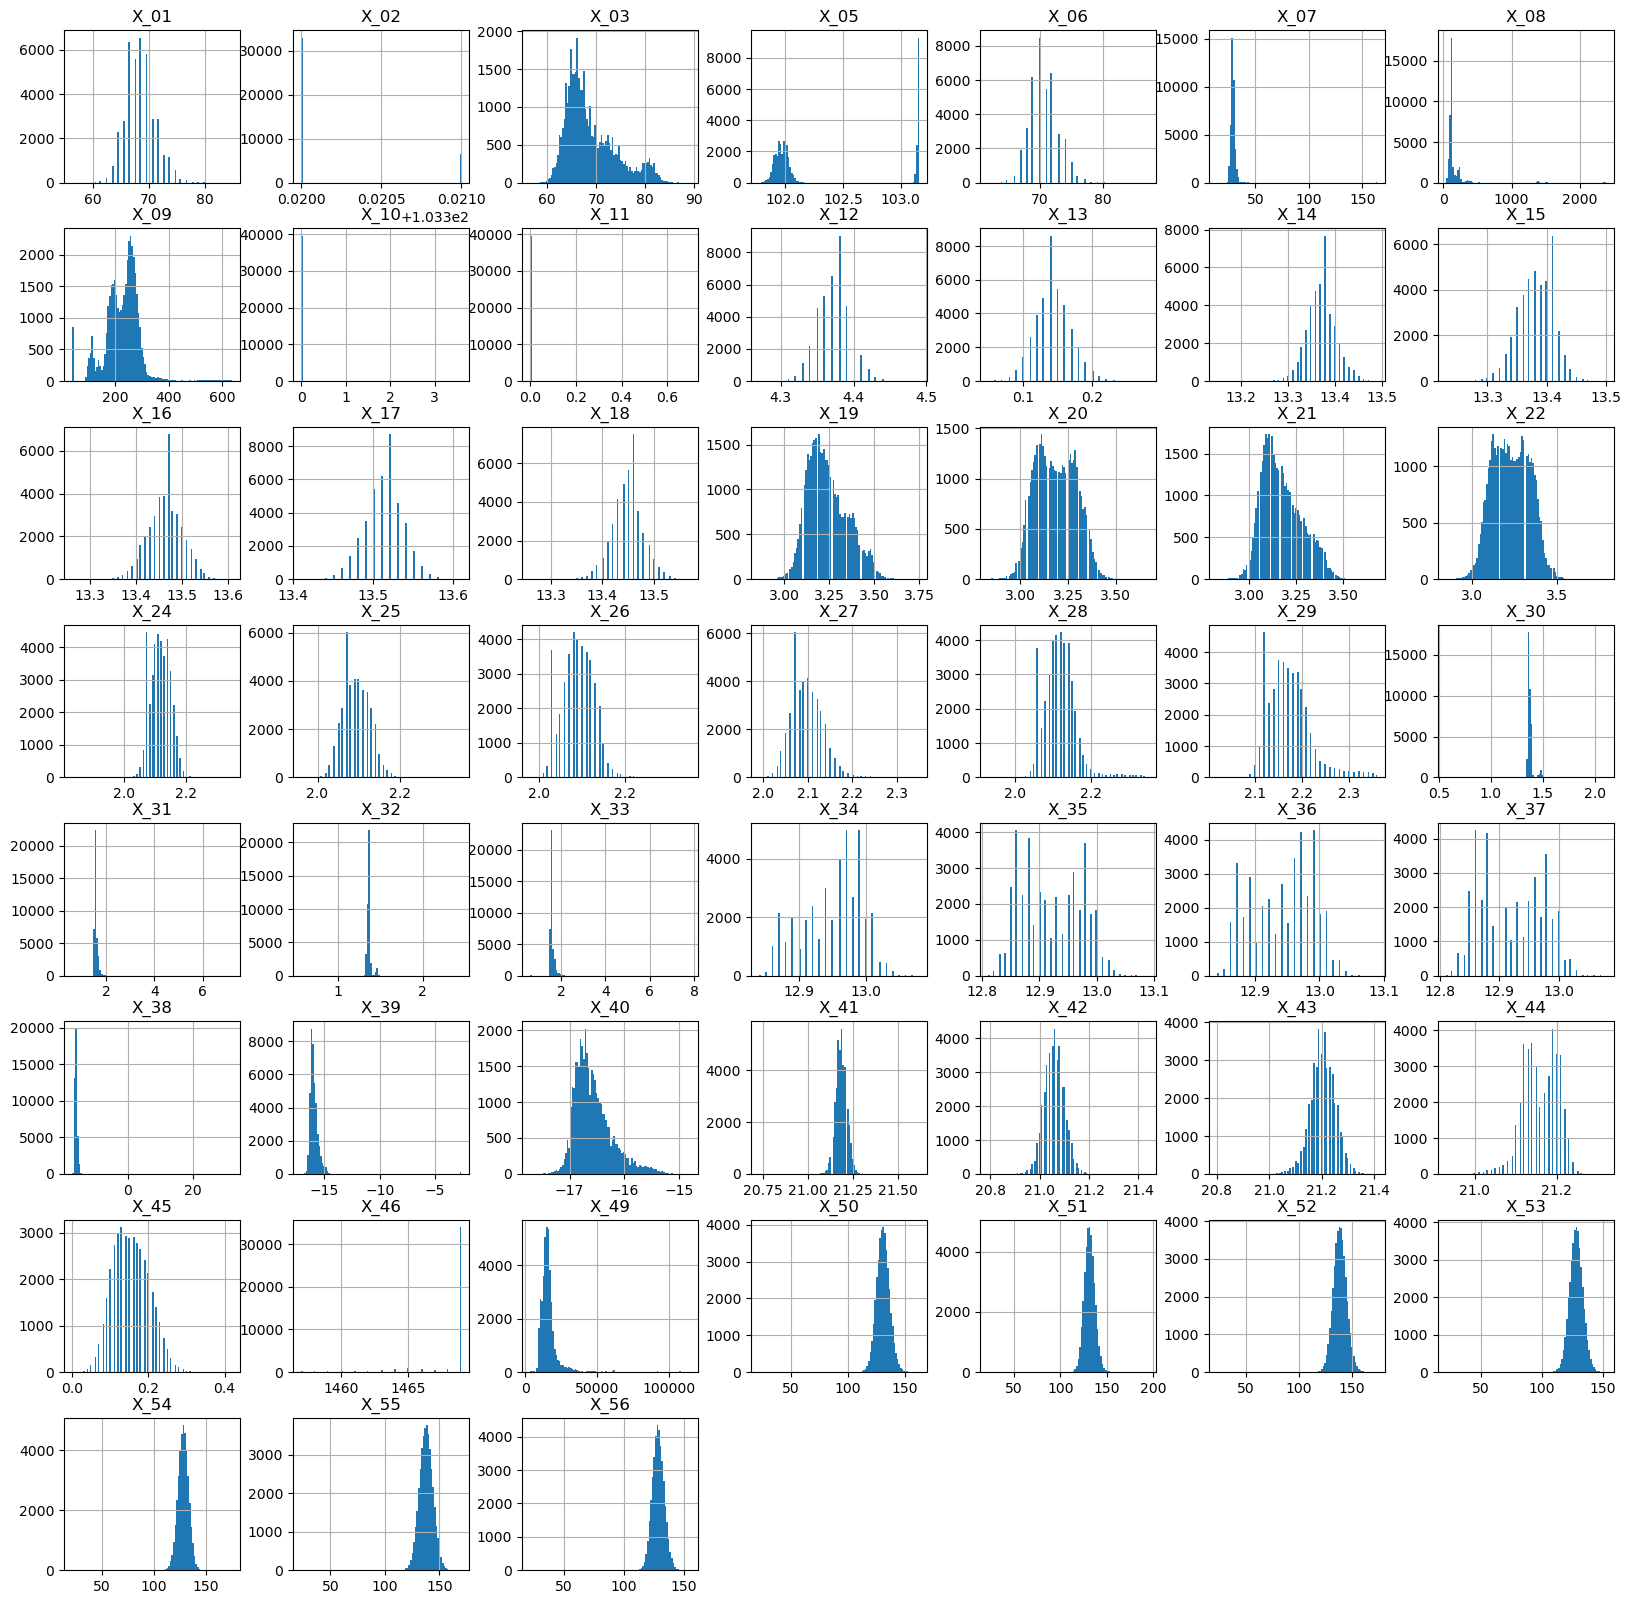

In [11]:
x_feature = df.filter(regex='^X_*') # Input : X Featrue
x_feature.hist(bins=100, figsize=(20, 20))
plt.show()

In [13]:
abnormal_feature =['X_02', 'X_10', 'X_11', 'X_46']

for abf in abnormal_feature:
    feauter_vc = df[abf].value_counts()
    print(abf)
    print(feauter_vc)
    print()

X_02
103.320    33020
103.321     6587
Name: X_02, dtype: int64

X_10
0.0    39575
2.9       12
3.0       12
3.3        4
3.1        2
3.6        1
3.2        1
Name: X_10, dtype: int64

X_11
0.0    39580
0.5       12
0.6       11
0.4        3
0.7        1
Name: X_11, dtype: int64

X_46
1469    34088
1465      881
1464      780
1468      696
1466      610
1463      549
1467      389
1462      365
1461      308
1460      305
1459      259
1458      197
1457      180
Name: X_46, dtype: int64



In [16]:
df['X_46'].nunique()

13

In [22]:
x_46_vc = df['X_46'].value_counts().reset_index()
x_46_vc.columns = ['name', 'value']

import plotly.express as px

fig = px.pie(data_frame=x_46_vc, names='name', values='value')
fig.update_traces(hole=.3)
fig.show()

1. X_02 (PCB 체결시 단계별 누름량)은 2개의 값으로 이루어짐 
2. X_10 (방열재료 2의 무게)과 X_11(방열재료 3의 무게)의 데이터의 99.9%가 0.0에 몰려있어 결측치로 의심됨
   
   하지만 의미있는 값일수도 있기때문에 모델을 학습 후 변수 중요도를 확인 후 제외할 예정임
3. X_46 (실란트 본드 소요량)은 86.1% 값이 1469로 편중되어있음
4. 해당 데이터 이외에도 이상치가 많은 Feature들이 보이나 도메인 지식이 없어 실제 이상치인지 확인할 수 없음. 따라서 모델 학습 후 Feature Selection을 진행할 예정

---

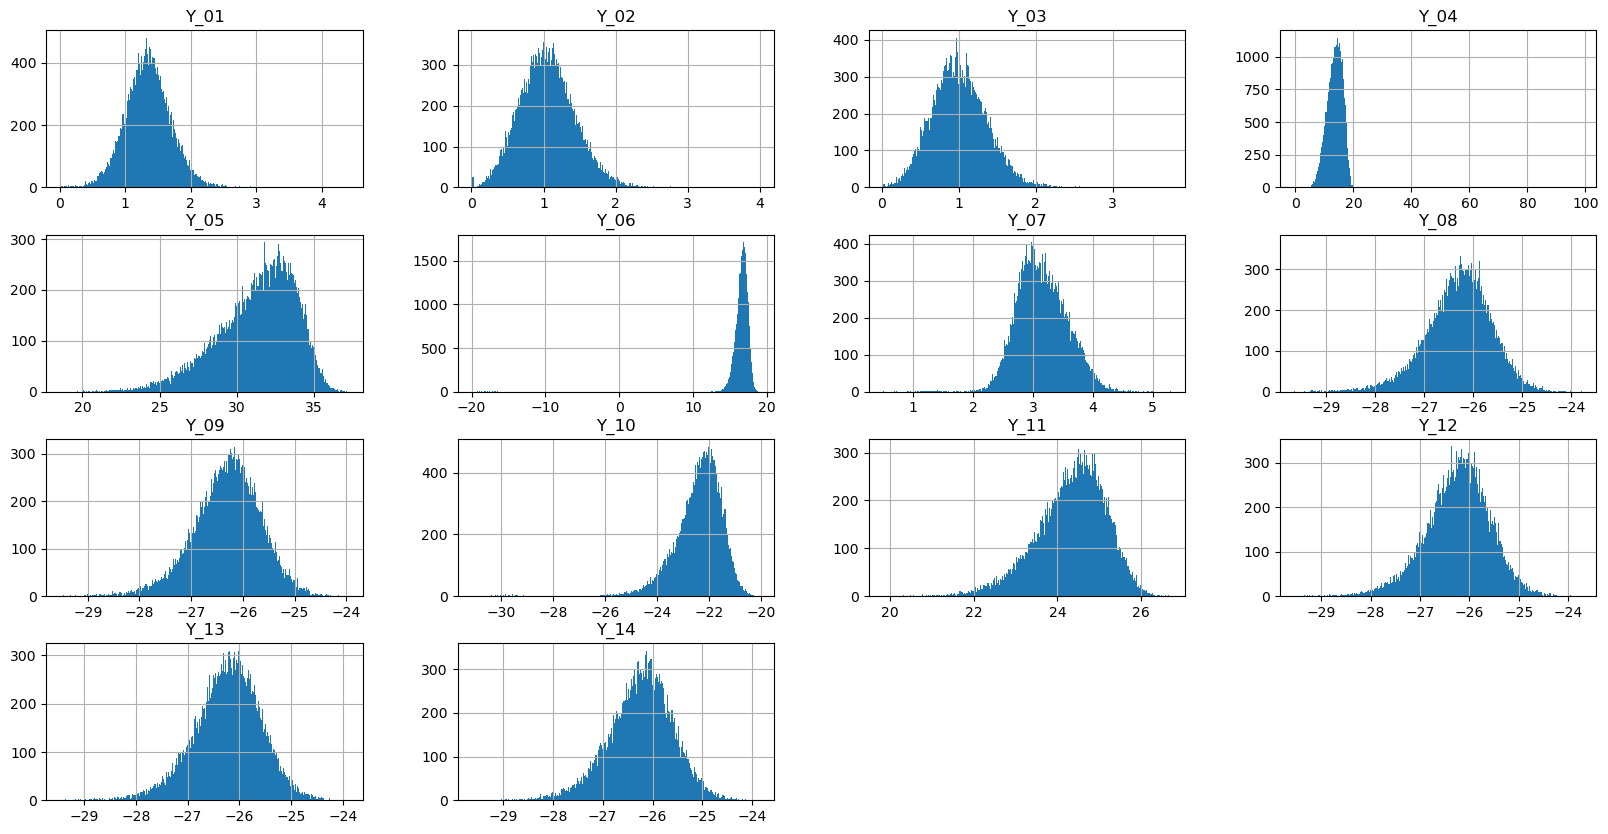

In [14]:
y_feature = df.filter(regex='^Y_*') # Output : Y Feature
y_feature.hist(bins=500, figsize=(20, 10))
plt.show()

## **모델**

In [ ]:
from sklearn.model_selection import train_test_split

x_train_val, x_test, y_train_val, y_test = train_test_split(x_feature, y_feature, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val =train_test_split(x_train_val, y_train_val, test_size = 0.25, random_state=0)

print(f'x_train: {x_train.shape}, x_val: {x_val.shape}, x_test: {x_test.shape}')
print(f'y_train: {x_train.shape}, y_val: {x_val.shape}, y_test: {y_test.shape}')

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

scaler = StandardScaler()
scaler.fit(x_train)

x_train_zscale = scaler.transform(x_train)
x_val_zscale = scaler.transform(x_val)
x_test_zscale = scaler.transform(x_test) 

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

for alpha in [0, 0.5, 1, 3, 5, 10, 100, 1000]:
    regressor = MultiOutputRegressor(Ridge(alpha=alpha, random_state=0)).fit(x_train_zscale, y_train)
    x_val_pred = regressor.predict(x_val_zscale)
    mse = mean_squared_error(y_val, x_val_pred)
    print(f"{alpha, mse}") 

In [ ]:
for solver in ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']:
    regressor = MultiOutputRegressor(Ridge(solver=solver, random_state=0)).fit(x_train_zscale, y_train)
    x_val_pred = regressor.predict(x_val_zscale)
    mse = mean_squared_error(y_val, x_val_pred)
    print(f"{solver, mse}") 

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(object='reg:squarederror', random_state=0)
xgb_model.fit(x_train_zscale, y_train)
y_pred_xgb = xgb_model.predict(x_val_zscale)
mse = mean_squared_error(y_val, y_pred_xgb)
print(mse)


In [ ]:
importances = xgb_model.feature_importances_
importances.shape

In [ ]:
plt.plot(importances)

In [ ]:
importances = multioutput_xgb_model.feature_importances_

In [ ]:
xgb_model = multioutput_xgb_model.estimators_[0]
xgb_model.fit(x_train_zscale, y_train[:,0])

importances = xgb_model.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.barh(range(x_train_zscale.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(x_train_zscale.shape[1]), [f"Feature {i}" for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Variable Importance')
plt.show()

## **모델**

## **결론**